# Análisis Predictivo de Bitcoin: Precio y Volatilidad con Deep Learning
## Análisis Exploratorio

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar dataset
df = pd.read_csv("btc_1d_data_2018_to_2025.csv")

# Selección de columnas
df = df[['Open time', 'Close']].rename(columns={'Open time': 'Date', 'Close': 'Close'})

# Conversión de tipos
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = pd.to_numeric(df['Close'], errors='coerce')

# Limpieza
df = df.dropna().sort_values('Date')

print("Shape final:", df.shape)
print("Rango fechas:", df['Date'].min(), "→", df['Date'].max())
print("Duración en días:", (df['Date'].max() - df['Date'].min()).days)


Shape final: (2594, 2)
Rango fechas: 2018-01-01 00:00:00 → 2025-02-06 00:00:00
Duración en días: 2593


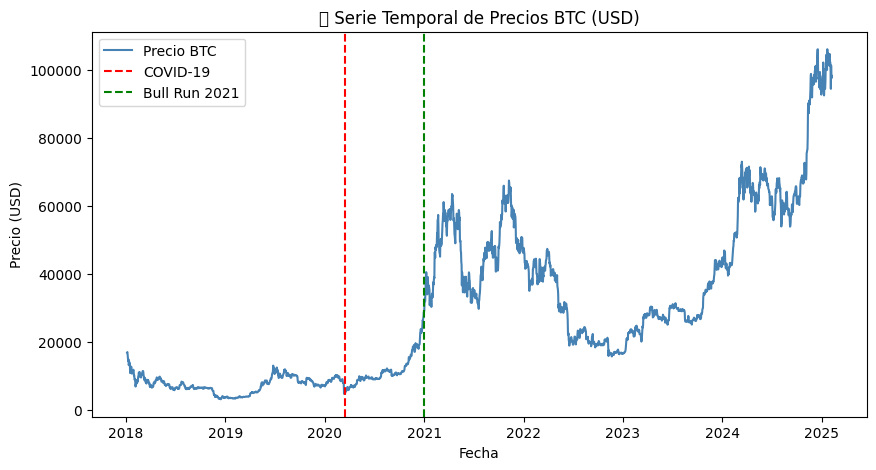

In [24]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'], df['Close'], label='Precio BTC', color='steelblue')

# Eventos destacados
plt.axvline(pd.to_datetime("2020-03-15"), color='red', linestyle='--', label='COVID-19')
plt.axvline(pd.to_datetime("2021-01-01"), color='green', linestyle='--', label='Bull Run 2021')

plt.title("📈 Serie Temporal de Precios BTC (USD)")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.legend()
plt.show()
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1))

# Eliminar el primer NaN generado por el shift
df = df.dropna(subset=['log_return'])


El gráfico de la serie temporal del precio de Bitcoin muestra un crecimiento significativo con ciclos de expansión y contracción. Se observan caídas abruptas durante el inicio de la pandemia de COVID-19 (marzo 2020), así como un incremento acelerado en el bull run de 2021. Posteriormente, el precio atraviesa una fuerte corrección en 2022, para luego recuperar tendencia alcista hacia 2024–2025. Esto confirma que Bitcoin es altamente sensible a eventos externos y presenta una dinámica especulativa marcada por fases de volatilidad extrema


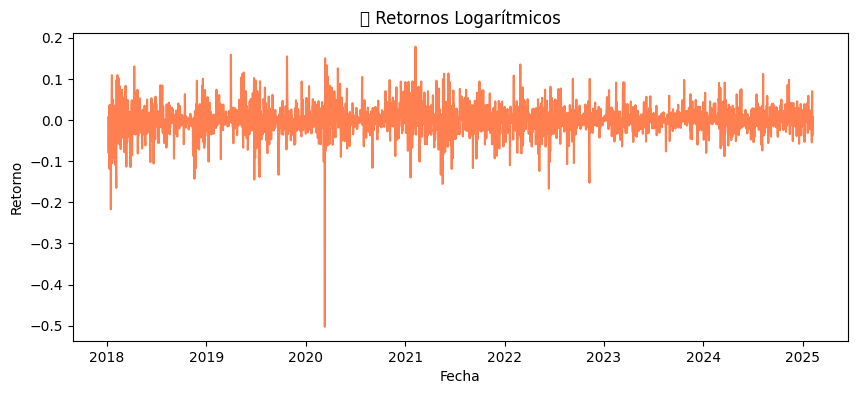

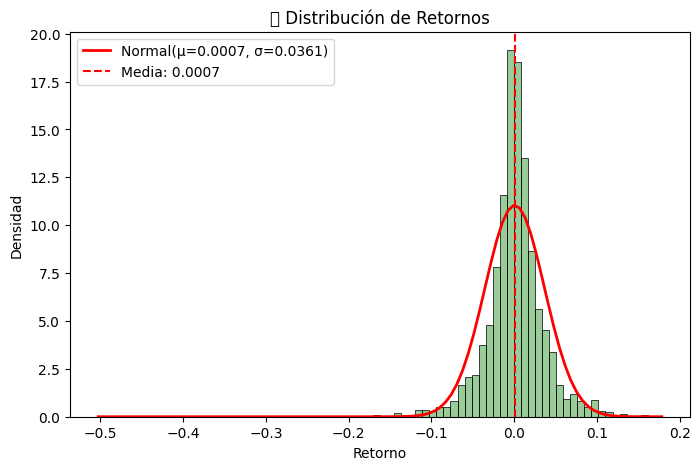

In [25]:
import seaborn as sns
from scipy.stats import norm

mu, sigma = df['LogRet'].mean(), df['LogRet'].std()
df['LogRet'] = np.log(df['Close'] / df['Close'].shift(1)).dropna()

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['LogRet'], color='coral')
plt.title("📉 Retornos Logarítmicos")
plt.xlabel("Fecha")
plt.ylabel("Retorno")
plt.show()


plt.figure(figsize=(8,5))
sns.histplot(df['LogRet'], bins=80, kde=False, stat="density", color="green", alpha=0.4)

# Curva normal ajustada
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
plt.plot(x, norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'Normal(μ={mu:.4f}, σ={sigma:.4f})')

plt.axvline(mu, color='red', linestyle='--', label=f"Media: {mu:.4f}")
plt.title("📊 Distribución de Retornos")
plt.xlabel("Retorno")
plt.ylabel("Densidad")
plt.legend()
plt.show()



en el grafico de retornos
observamos que los retornos logarítmicos se concentran en torno a cero, pero presentan valores extremos en momentos de crisis (ej. COVID-19 en 2020) y durante fases de fuerte expansión (bull run 2021). Esto evidencia que, aunque el promedio de retornos diarios es bajo, la dispersión es elevada, lo que refuerza la idea de que Bitcoin es un activo riesgoso con alta exposición a eventos de cola.

por otro lado la distribución de los retornos de Bitcoin presenta una media cercana a cero (μ ≈ 0.0008), con una dispersión relativamente alta (σ ≈ 0.0357). La comparación con la curva normal ajustada muestra que los retornos exhiben colas pesadas y mayor concentración alrededor de la media, lo cual indica un comportamiento no gaussiano. Esto implica que los modelos que asumen normalidad subestiman la probabilidad de eventos extremos

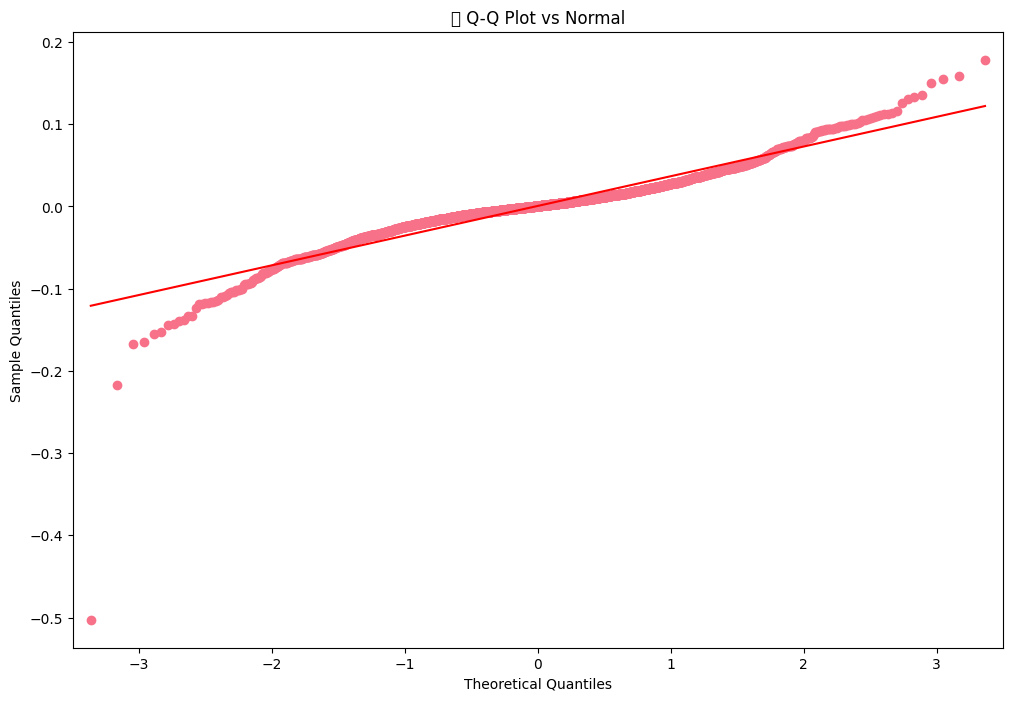

In [26]:
import statsmodels.api as sm

sm.qqplot(df['LogRet'].dropna(), line='s')
plt.title("📐 Q-Q Plot vs Normal")
plt.show()


como ya habiamos dicho, el Q-Q plot muestra desviaciones claras en las colas respecto a la distribución normal: los puntos se alejan de la línea de referencia tanto en valores extremos negativos como positivos. Esto confirma que los retornos de Bitcoin no son normales y presentan riesgo de eventos extremos, en especial negativos. En otras palabras, el mercado de BTC es más volátil y arriesgado de lo que asumiría un modelo gaussiano.”

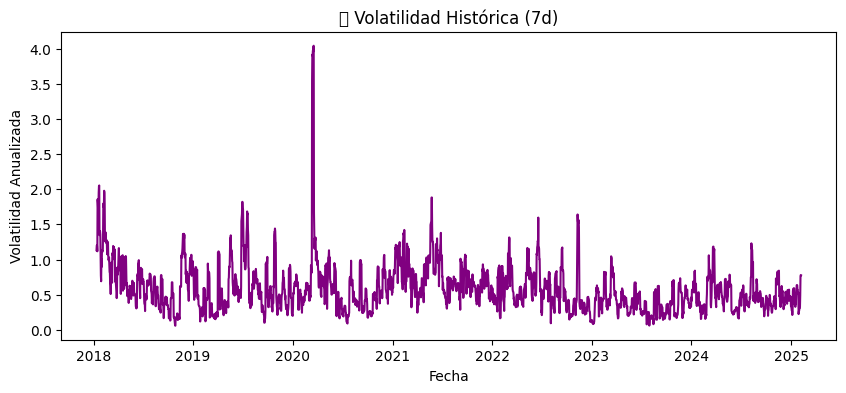

In [27]:
window = 7
df['Vol_7d'] = df['LogRet'].rolling(window).std() * np.sqrt(365)  # anualizada

plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Vol_7d'], color='purple')
plt.title("📉 Volatilidad Histórica (7d)")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad Anualizada")
plt.show()


La volatilidad histórica calculada con una ventana de 7 días muestra episodios de clustering de volatilidad: periodos de calma seguidos de picos muy altos. En particular, se observan valores extremos durante la pandemia de COVID-19 y el bull run de 2021. Esto confirma que la volatilidad de Bitcoin no es constante en el tiempo, sino que presenta heterocedasticidad lo cual nos da sugerencias sobre que tipo de modelos podrian ser mas efectivos en este problema especifico

weekday
Friday       0.035117
Monday       0.041776
Saturday     0.023354
Sunday       0.028639
Thursday     0.045376
Tuesday      0.036060
Wednesday    0.037713
Name: log_return, dtype: float64


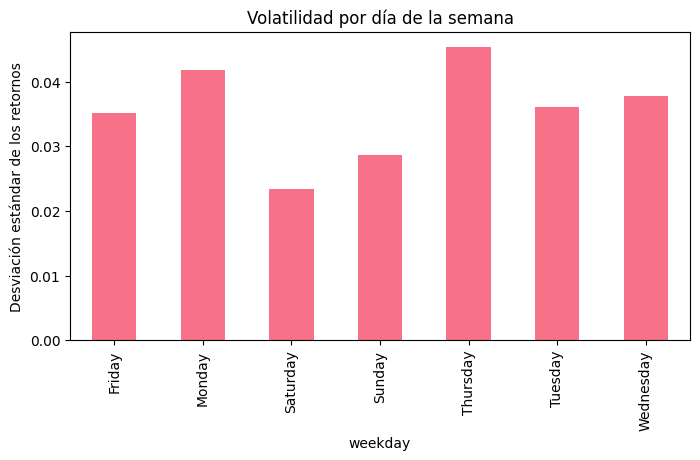

In [28]:
# Asegurar columna fecha
df['Date'] = pd.to_datetime(df['Date'])

# Retornos logarítmicos
df['log_return'] = np.log(df['Close']).diff()

# Día de la semana (0=lunes, 6=domingo)
df['weekday'] = df['Date'].dt.day_name()

# Volatilidad por día de la semana
vol_by_weekday = df.groupby('weekday')['log_return'].std().sort_index()

print(vol_by_weekday)

# Visualización
vol_by_weekday.plot(kind='bar', figsize=(8,4), title="Volatilidad por día de la semana")
plt.ylabel("Desviación estándar de los retornos")
plt.show()


El EDA revela fuerte estacionalidad semanal y posible heterocedasticidad, esto nos indica promesa sobre los lagas mas grandes capaces de atrapar estas variaciones

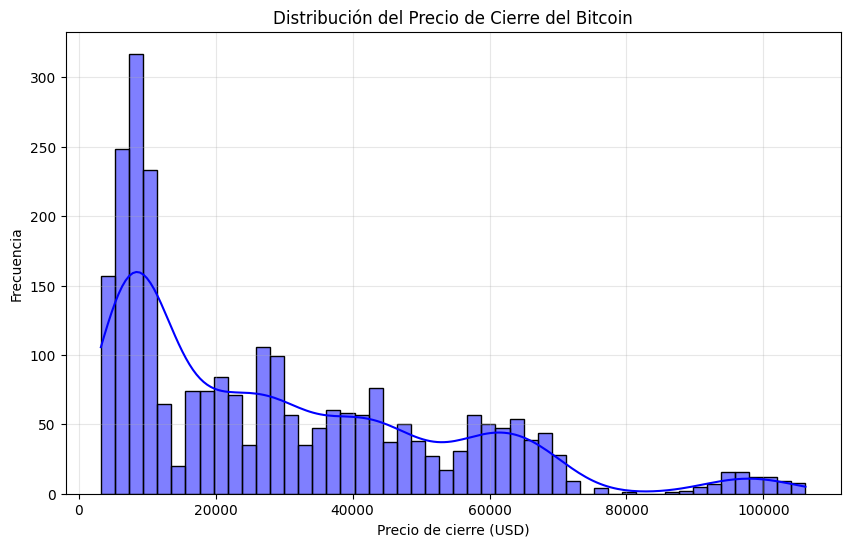

count      2594.000000
mean      29090.193446
std       23576.229505
min        3211.720000
25%        9068.840000
50%       22741.115000
75%       43527.390000
max      106143.820000
Name: Close, dtype: float64

In [11]:
# Estadísticas descriptivas del precio de cierre
desc_stats = df['Close'].describe()

# Histograma y KDE del precio de cierre
plt.figure(figsize=(10,6))
sns.histplot(df['Close'], bins=50, kde=True, color="blue")
plt.title("Distribución del Precio de Cierre del Bitcoin")
plt.xlabel("Precio de cierre (USD)")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

desc_stats
